In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

In [2]:
from bimpcc.dataset import get_blur_dataset
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.recons_regularized import TVReconsRegularized
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 20

In [5]:
dataset = get_blur_dataset("cameraman",scale=scale)
true, blurred = dataset.get_training_data()

(np.float64(-0.5), np.float64(19.5), np.float64(19.5), np.float64(-0.5))

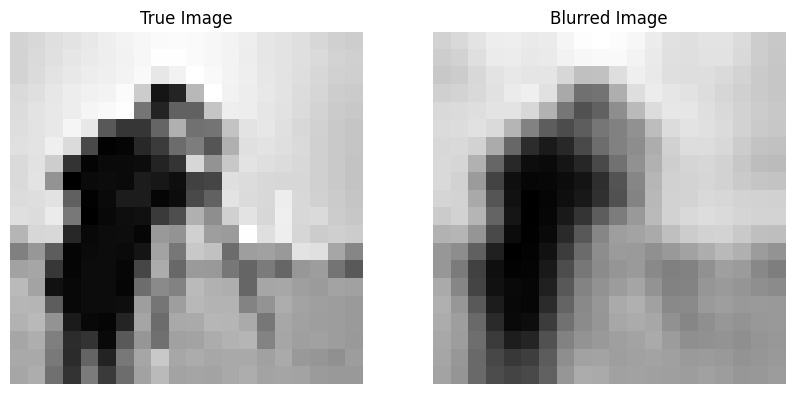

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(blurred,cmap='gray')
ax[1].set_title('Blurred Image')
ax[1].axis('off')

In [7]:
from bimpcc.utils import gaussian_blur_sparse_matrix_symmetric
forward_map = gaussian_blur_sparse_matrix_symmetric(true.shape)
model = TVReconsRegularized(forward_map, true, blurred, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    14840
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:     1161
                     variables with only lower bounds:      401
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1160
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

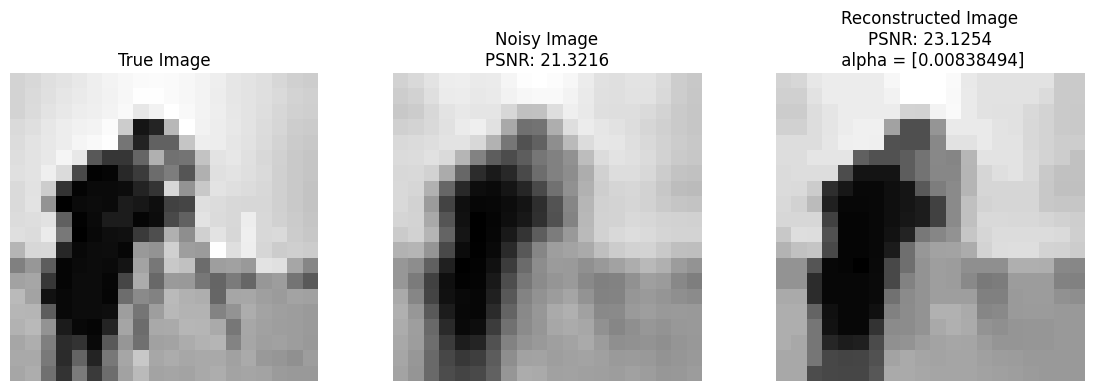

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,blurred,u,alpha)